In [252]:
# Bismilah 
# Fréquence trimestrielle
# Serie positive
# Pas de dates fournies => on creer un index temporelle artificiel

# on ne méllange jamais la serie 



In [253]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import sns
from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


data = pd.read_csv("data/Quarterly-train.csv")

Le dataset M4 est fourni en format wide : chaque colonne correspond à une série temporelle distincte. L’analyse est réalisée sur une seule série (V1), conformément aux recommandations du cours.

Une ligne = un instant t

Une colonne = l’évolution dans le temps


Une série temporelle est une suite de valeurs d’une même variable observée à différents instants.

## 1-Preparation de données

In [254]:
data_clean = data.melt(id_vars='V1', var_name='V', value_name='VALUE')

data_clean['TIME'] = data_clean['V'].str[1:].astype(int) -1

data_clean = data_clean.rename(columns={'V1': 'ID'})

data_clean = data_clean.dropna(subset=['VALUE'])

data_clean = data_clean.sort_values(['ID', 'TIME'])

data_clean['TIME'] = data_clean.groupby('ID').cumcount() + 1

data_clean = data_clean[['ID', 'TIME', 'VALUE']].reset_index(drop=True)

print(data_clean.head(10))


   ID  TIME        VALUE
0  Q1     1  7407.412314
1  Q1     2  7528.566074
2  Q1     3  7374.709225
3  Q1     4  7395.514848
4  Q1     5  7654.007989
5  Q1     6  7686.847835
6  Q1     7  7578.190743
7  Q1     8  7904.376716
8  Q1     9  7744.049254
9  Q1    10  7889.909013


In [255]:
first_quarterly = data_clean[data_clean['ID'] == data_clean['ID'].unique()[0]]
serie = first_quarterly["VALUE"]

In [256]:
serie.head()

0    7407.412314
1    7528.566074
2    7374.709225
3    7395.514848
4    7654.007989
Name: VALUE, dtype: float64

In [257]:
serie.info()

<class 'pandas.core.series.Series'>
Index: 25 entries, 0 to 24
Series name: VALUE
Non-Null Count  Dtype  
--------------  -----  
25 non-null     float64
dtypes: float64(1)
memory usage: 400.0 bytes


In [258]:
serie.dtype

dtype('float64')

## 2 Creation de l'index trimestriel

In [259]:
serie.index = pd.period_range(
    start = "2000Q1",
    periods = len(serie),
    freq = "Q"
)

In [260]:
# Créer l’index temporel (trimestriel) car pour l'instant la serie à un index numerique 

serie.head()

2000Q1    7407.412314
2000Q2    7528.566074
2000Q3    7374.709225
2000Q4    7395.514848
2001Q1    7654.007989
Freq: Q-DEC, Name: VALUE, dtype: float64

In [261]:
serie.index

PeriodIndex(['2000Q1', '2000Q2', '2000Q3', '2000Q4', '2001Q1', '2001Q2',
             '2001Q3', '2001Q4', '2002Q1', '2002Q2', '2002Q3', '2002Q4',
             '2003Q1', '2003Q2', '2003Q3', '2003Q4', '2004Q1', '2004Q2',
             '2004Q3', '2004Q4', '2005Q1', '2005Q2', '2005Q3', '2005Q4',
             '2006Q1'],
            dtype='period[Q-DEC]')

In [262]:
serie.shape

(25,)

In [263]:
serie.head(10)

2000Q1    7407.412314
2000Q2    7528.566074
2000Q3    7374.709225
2000Q4    7395.514848
2001Q1    7654.007989
2001Q2    7686.847835
2001Q3    7578.190743
2001Q4    7904.376716
2002Q1    7744.049254
2002Q2    7889.909013
Freq: Q-DEC, Name: VALUE, dtype: float64

## 3-visualisation de la serie 

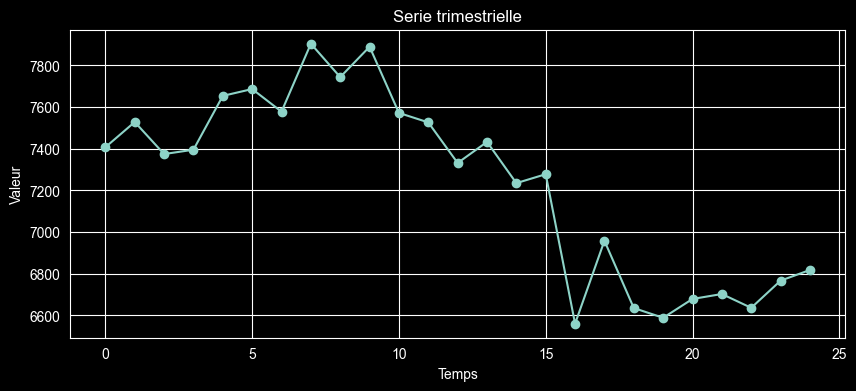

In [264]:
# visualisation de la serie 

plt.figure(figsize=(10,4))
plt.plot(serie.values, marker='o')
plt.title("Serie trimestrielle")
plt.xlabel("Temps")
plt.ylabel("Valeur")
plt.grid(True)
plt.show()

La série ne présente pas de tendance ni de saisonnalité trimestrielle clairement identifiables, mais une forte variabilité et des fluctuations irrégulières.

In [265]:
serie.head()

2000Q1    7407.412314
2000Q2    7528.566074
2000Q3    7374.709225
2000Q4    7395.514848
2001Q1    7654.007989
Freq: Q-DEC, Name: VALUE, dtype: float64

In [266]:
serie.dtype

dtype('float64')

## 4- Decomposition saisonière


<Figure size 1200x800 with 0 Axes>

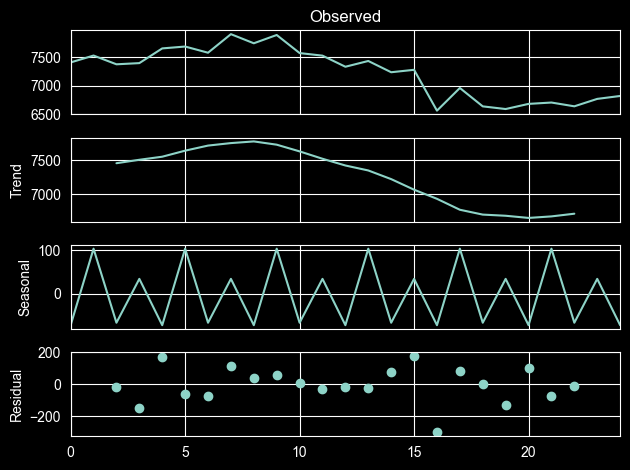

In [267]:
seasons = seasonal_decompose(serie.values, model='additive', period=4)

plt.figure(figsize=(12, 8))
seasons.plot()
plt.show()

## 4-Test de stationnarité (ADF)

In [268]:
from statsmodels.tsa.stattools import adfuller

# Est-ce que la série est stationnaire ou non ?

result = adfuller(serie)

# H₀ : la série n’est pas stationnaire

# H₁ : la série est stationnaire

In [269]:
print("ADF Statistic :", result[0])
print("p-value       :", result[1])


ADF Statistic : -0.4637341550076648
p-value       : 0.8989013636938894


Comme notre série n'est pas stationnaire nous devons faire la différenciation

In [270]:
serie = serie.diff().dropna()

print(serie)

2000Q2    121.153760
2000Q3   -153.856849
2000Q4     20.805623
2001Q1    258.493141
2001Q2     32.839847
2001Q3   -108.657092
2001Q4    326.185973
2002Q1   -160.327463
2002Q2    145.859760
2002Q3   -317.797744
2002Q4    -45.418346
2003Q1   -194.846988
2003Q2    101.295180
2003Q3   -198.006537
2003Q4     42.872737
2004Q1   -717.775919
2004Q2    398.315999
2004Q3   -323.064941
2004Q4    -46.817756
2005Q1     90.409460
2005Q2     23.781411
2005Q3    -66.339118
2005Q4    130.430680
2006Q1     51.219605
Freq: Q-DEC, Name: VALUE, dtype: float64


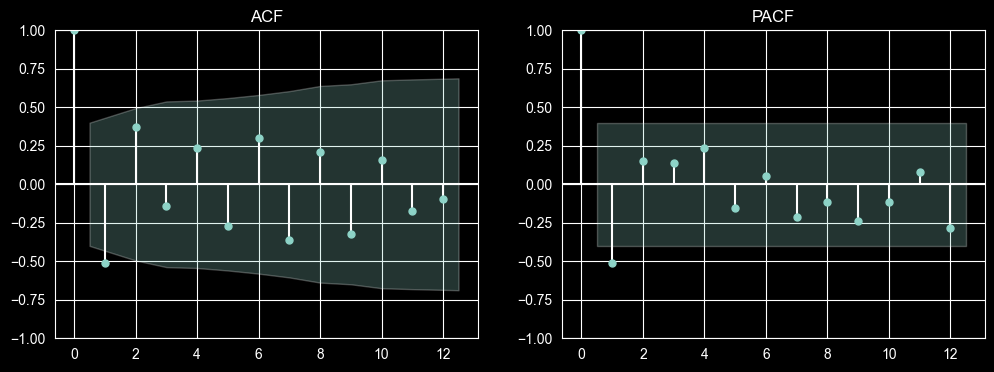

In [271]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12,4))

plot_acf(serie, ax=axes[0])
axes[0].set_title("ACF")

plot_pacf(serie, ax=axes[1], method="ywm")
axes[1].set_title("PACF")

plt.show()


Lecture de l’ACF (à gauche)

les autocorrélations restent faibles

la majorité des barres est dans l’intervalle de confiance

Lecture de la PACF (à droite)

Pas de structure AR claire
Pas de modèle AR(p) dominant

Les fonctions d’autocorrélation et d’autocorrélation partielle ne révèlent pas de structure AR ou MA marquée, suggérant que la série peut être assimilée à un bruit blanc stationnaire ou modélisée par un ARIMA de faible ordr

AR = AutoRegressive  Yt​=c+ϕ1​Yt−1​+ϕ2​Yt−2​+⋯+ϕp​Yt−p​+εt​
MA = Moving Average  Yt​=μ+εt​+θ1​εt−1​+⋯+θq​εt−q​


Un modèle AR capture la dépendance entre les observations passées, tandis qu’un modèle MA modélise l’impact des chocs aléatoires passés sur la série.

In [272]:
from statsmodels.tsa.arima.model import ARIMA

model_000 = ARIMA(serie, order=(0,0,0))
result_000 = model_000.fit()

print(result_000.summary())

                               SARIMAX Results                                
Dep. Variable:                  VALUE   No. Observations:                   24
Model:                          ARIMA   Log Likelihood                -164.505
Date:                Thu, 12 Feb 2026   AIC                            333.010
Time:                        16:41:29   BIC                            335.366
Sample:                    06-30-2000   HQIC                           333.635
                         - 03-31-2006                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -24.5519     52.184     -0.470      0.638    -126.830      77.727
sigma2      5.259e+04   1.26e+04      4.161      0.000    2.78e+04    7.74e+04
Ljung-Box (L1) (Q):                   7.17   Jarque-

In [273]:
# ARIMA(1,0,0) (petit effet AR)
model_100 = ARIMA(serie, order=(1,0,0))
result_100 = model_100.fit()

print(result_100.summary())


                               SARIMAX Results                                
Dep. Variable:                  VALUE   No. Observations:                   24
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -160.875
Date:                Thu, 12 Feb 2026   AIC                            327.751
Time:                        16:41:29   BIC                            331.285
Sample:                    06-30-2000   HQIC                           328.689
                         - 03-31-2006                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -27.8431     32.580     -0.855      0.393     -91.698      36.012
ar.L1         -0.5050      0.300     -1.681      0.093      -1.094       0.084
sigma2      3.848e+04   8706.174      4.420      0.0

In [274]:
# ARIMA(0,0,1) (petit effet MA)
model_001 = ARIMA(serie, order=(0,0,1))
result_001 = model_001.fit()

print(result_001.summary())


                               SARIMAX Results                                
Dep. Variable:                  VALUE   No. Observations:                   24
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -162.218
Date:                Thu, 12 Feb 2026   AIC                            330.435
Time:                        16:41:29   BIC                            333.969
Sample:                    06-30-2000   HQIC                           331.373
                         - 03-31-2006                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -28.6520     34.415     -0.833      0.405     -96.104      38.800
ma.L1         -0.3439      0.267     -1.286      0.198      -0.868       0.180
sigma2      4.333e+04   1.02e+04      4.268      0.0

Le modèle ARIMA(0,0,1) présente un bon ajustement, avec un paramètre MA significatif et des résidus assimilables à un bruit blanc selon le test de Ljung-Box. Il constitue un modèle adéquat pour cette série.

In [275]:
# Comparaison des  models 

print("ARIMA(0,0,0) AIC :", result_000.aic)
print("ARIMA(1,0,0) AIC :", result_100.aic)
print("ARIMA(0,0,1) AIC :", result_001.aic)


ARIMA(0,0,0) AIC : 333.0102952481136
ARIMA(1,0,0) AIC : 327.75098456267546
ARIMA(0,0,1) AIC : 330.43516611654684


Plusieurs modèles ARIMA de faible ordre ont été estimés. Le modèle retenu est celui minimisant le critère AIC, indiquant un compromis optimal entre qualité d’ajustement et complexité.

In [276]:
# residuals = result_000.resid
#
# plt.figure(figsize=(10,4))
# plt.plot(residuals)
# plt.title("Résidus du modèle")
# plt.grid(True)
# plt.show()
#
# plot_acf(residuals)
# plt.show()


## 5- Stabilité des cycles saisonniers

C:\Users\Abdallah Toumji\AppData\Local\Temp\ipykernel_32084\2348974061.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_quarterly['Quarter_Cycle'] = (first_quarterly['TIME'] - 1) % 4 + 1


<Axes: title={'center': 'VALUE'}, xlabel='Quarter_Cycle'>

<Figure size 1000x600 with 0 Axes>

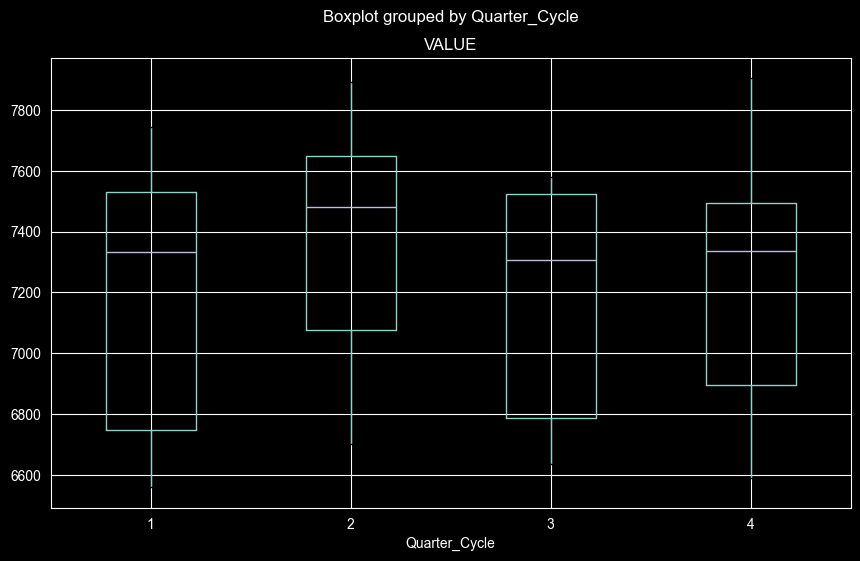

In [277]:
first_quarterly['Quarter_Cycle'] = (first_quarterly['TIME'] - 1) % 4 + 1
plt.figure(figsize=(10, 6))

first_quarterly.boxplot(column='VALUE', by='Quarter_Cycle', figsize=(10, 6))